In [16]:
import dgl
import numpy as np
import torch
import networkx as nx
import os
import matplotlib.pyplot as plt
os.environ['DGLBACKEND'] = 'pytorch'

from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dgl.nn import NNConv, EdgeConv
from dgl.nn.pytorch import Sequential as dglSequential
from dgl.dataloading import GraphDataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

from pytorch_model_summary import summary

## Dataloader

In [2]:
data_path = '../data/graphdataset/'

In [3]:
class GraphDataset(Dataset):
    def __init__(self, data_path, n_files=None, lbl_to_load=None, transform=None):

        self.fnames    = [fname for fname in os.listdir(data_path) if fname.endswith('.dgl')]
        self.data_path = data_path

        if n_files:
            self.fnames = self.fnames[n_files]

        self.transform = transform     
        self.lbl_2_load = lbl_to_load

        self.load_graphs()


    def load_graphs(self):
        self.graphs = []

        for fname in tqdm(self.fnames, 'Reading files'):
            graphs, _ = dgl.load_graphs(os.path.join(self.data_path, fname))
            if self.lbl_2_load:
                self.graphs.extend([graph for graph in graphs if graph.ndata['labels'][0].nonzero().squeeze() in self.lbl_2_load])
            else:
                self.graphs.extend(graphs)


    def __len__(self):

        return len(self.graphs)
    

    def __getitem__(self, idx):

        x = self.graphs[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x

In [4]:
train_files = slice(1)
val_files   = slice(1, )

labels_2_load = [0, 2, 4]

train_dataset = GraphDataset(data_path, train_files, labels_2_load)
val_dataset   = GraphDataset(data_path, val_files, labels_2_load)

Reading files:   0%|          | 0/1 [00:00<?, ?it/s]

Reading files:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
train_dataloader = GraphDataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader   = GraphDataLoader(val_dataset, batch_size=16, shuffle=True)
for batch in train_dataloader:
    break
print(len(train_dataloader))

757


## Simulated Graph
50 particelle, 7 features per particle, each node is connected to all the others so n**2 edges, each edge has 3 different features

In [ ]:
n = 50 
src = []; dst = []
for i in range(n):
    for j in range(n):
        src.append(i)
        dst.append(j)

g = dgl.graph((src, dst))

nodes = torch.randn((n, 7))
edges = torch.randn((n**2, 3))

g.ndata['feat'] = nodes
g.edata['edge_feat'] = edges


In [ ]:
def MLP(efeat, ch=[256,128,64,32]):

    mlp = nn.Sequential(
        nn.Linear(3, ch[0]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[0],ch[1]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[1],ch[2]),
        nn.Dropout(0.2),
        nn.ReLU(),

        nn.Linear(ch[2], ch[3]),
        nn.Dropout(0.2),
        nn.ReLU(),

        nn.Linear(ch[3], 7*128),
        nn.Sigmoid()
    )
    
    return mlp(efeat)

In [ ]:
conv = NNConv(7, 128, MLP)
res = conv(g, nodes, edges)
res.shape

torch.Size([50, 128])

## Encoder

In [12]:
class Encoder(nn.Module):
    
    def __init__(self, latent_space_dim, ch=[256,128,64,32]):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(3, ch[0]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[0],ch[1]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[1],ch[2]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[2], ch[3]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[3], 7*128),
            nn.Sigmoid()
            )
        
        self.conv = dglSequential(
            NNConv(
                in_feats  = 7,  # number of node features
                out_feats = 128, # output number of node features
                edge_func = self.mlp),
            EdgeConv(128, 64, batch_norm=True),
            EdgeConv(64, 32, batch_norm=True),
            EdgeConv(32, latent_space_dim, batch_norm=True)
        )

    def forward(self, graph, n_feat=None):

        x = self.conv(graph, n_feat if n_feat else graph.ndata['f'], graph.edata['d'])
        return x
    

In [9]:
encoder = Encoder(4)
encoded = encoder(batch)
encoded.shape

torch.Size([1010, 4])

In [11]:
batch.ndata['l'] = encoded

In [40]:
class NNConv_handy(nn.Module):

    def __init__(self, in_feat, out_feat, ch=[256,128,64,32]):
        super().__init__()

        self.mlp = nn.Sequential(
            *[self.block(cin, cout) for cin, cout in zip([3]+ch, ch)],
            nn.Linear(ch[-1], in_feat*out_feat),
            nn.Sigmoid()
        )

        self.nnconv = NNConv(in_feat, out_feat, edge_func=self.mlp)

    def block(self, cin, cout):
        return nn.Sequential(
            nn.Linear(cin, cout),
            nn.Dropout(0.2),
            nn.BatchNorm1d(cout),
            nn.ReLU())
    
    def forward(self, graph, nfeat):
        return self.nnconv(graph, nfeat, graph.edata['d'])

In [27]:
def block(self, cin, cout):
    return nn.Sequential(
            nn.Linear(cin, cout),
            nn.Dropout(0.2),
            nn.BatchNorm1d(cout),
            nn.ReLU())

In [ ]:
block()

In [31]:
ch = [256, 128, 64, 32]
in_feat = 7

for cin, cout in zip([in_feat]+ch, ch):
    print(cin, cout)

7 256
256 128
128 64
64 32


In [41]:
nnc = NNConv_handy(7, 128, [32, 64, 128, 256])
nnc.mlp

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (3): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (4): Linear(in_features=256, out_features=896, bias=True)
  (5): Sigmoid()

In [42]:
result = nnc(batch, batch.ndata['f'])

## Decoder

In [11]:
class Decoder(nn.Module):
    
    def __init__(self, latent_space_dim, n_feat=7):
        super().__init__()

        self.shared_path = dglSequential(
            EdgeConv(latent_space_dim, 32, batch_norm=True),
            EdgeConv(32, 64, batch_norm=True),
            EdgeConv(64, 128, batch_norm=True)
        )
        
        self.node_reconstruct = EdgeConv(128, n_feat)    # output are the reconstructed node features

        self.edge_reconstruct1 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

        self.edge_reconstruct2 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

        self.edge_reconstruct3 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

    def forward(self, graph, n_feat=None):
        
        if n_feat is None:
            n_feat = graph.ndata['l']

        # shared path
        shared = self.shared_path(graph, n_feat)

        # node reconstruction
        n = self.node_reconstruct(graph, shared)
        
        # edges reconstruction
        e1 = self.edge_reconstruct1(graph, shared)
        e2 = self.edge_reconstruct2(graph, shared)
        e3 = self.edge_reconstruct3(graph, shared)

        # inner product o matmul?
        e1 = torch.inner(e1, e1)  #their elements are A_{ij}
        e2 = torch.inner(e2, e2) 
        e3 = torch.inner(e3, e3)

        return n, torch.stack([e1, e2, e3], 2)
    

In [12]:
decoder = Decoder(4)
decoded = decoder(batch)

In [14]:
autoencoder = dglSequential(encoder, decoder)
n, e = autoencoder(batch)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
count_parameters(autoencoder)

147614

## Training

In [13]:
### Initialize the two networks
encoded_space_dim = 6
encoder = Encoder(latent_space_dim=encoded_space_dim)
decoder = Decoder(latent_space_dim=encoded_space_dim)

autoencoder = dglSequential(encoder, decoder)

### Learning Rate and Loss customize 

In [14]:
def custom_loss(output, target):
    """ pred and real are two tuples which contains:
    real: real nodes and edges
    real: real nodes and edges"""

    # regularization parameters    
    l_node = 0.3
    l_edge = 1
    
    loss_fn = torch.nn.MSELoss()
    node_loss = torch.sqrt(loss_fn(output[0], target[0])) 
    e0_loss = torch.sqrt(loss_fn(output[1], target[1])) 
    e1_loss = torch.sqrt(loss_fn(output[2], target[2]))
    e2_loss = torch.sqrt(loss_fn(output[3], target[3]))  

    return l_node * node_loss + l_edge * (e0_loss+e1_loss+e2_loss)


def nodes_loss(output, target):

    loss_fn = torch.nn.MSELoss()
    return torch.sqrt(loss_fn(output, target))   

def edges_loss(output, target):
    #dim = int(np.sqrt(target.shape[0]))
    loss_fn = torch.nn.MSELoss(reduction='none')
    edge_loss = torch.sum(torch.sqrt(torch.mean(loss_fn(output, target), dim=[0, 1])))

    return edge_loss

In [36]:
### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
loss_fn = custom_loss
params_to_optimize = [
    {'params': [param for param in encoder.parameters() if param.requires_grad]},
    {'params': [param for param in decoder.parameters() if param.requires_grad]}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

"""
usando questo bisogna fare scheduler.step(val_loss) alla fine di un epoca
"""
'''lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor=0.5,
    patience=5,
    cooldown=5,
    min_lr=10e-8, # this should be the minimum value of the lr at which we stop the training
    threshold=1e-2
    )
'''

encoder.to(device)
decoder.to(device)
autoencoder.to(device)

Selected device: cuda


Sequential(
  (0): Encoder(
    (mlp): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): Dropout(p=0.2, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): ReLU()
      (9): Linear(in_features=64, out_features=32, bias=True)
      (10): Dropout(p=0.2, inplace=False)
      (11): ReLU()
      (12): Linear(in_features=32, out_features=896, bias=True)
      (13): Sigmoid()
    )
    (conv): Sequential(
      (0): NNConv(
        (edge_func): Sequential(
          (0): Linear(in_features=3, out_features=256, bias=True)
          (1): Dropout(p=0.2, inplace=False)
          (2): ReLU()
          (3): Linear(in_features=256, out_features=128, bias=True)
          (4): Dropout(p=0.2, inplace=False)
          (5): ReLU()
          (6): Linear(in

/home/ubuntu/data/miniconda3/envs/torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1282: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/ubuntu/data/miniconda3/envs/torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


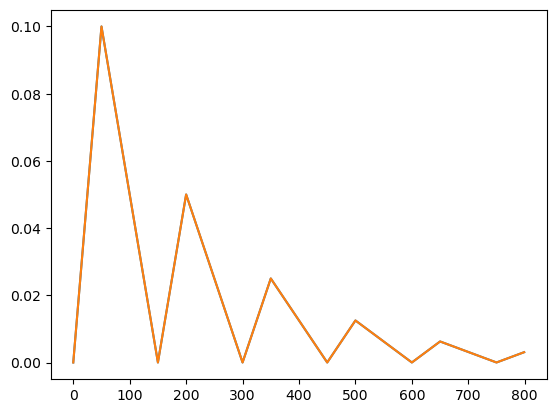

In [39]:


scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-5, 1e-1, 50, 100, mode='triangular2',cycle_momentum=False)
x=np.arange(800)
lrs = []
for i in x:
    lrs.append(scheduler.get_lr())
    scheduler.step()
plt.plot(x, lrs)


In [32]:
scheduler.get_lr()

/home/ubuntu/data/miniconda3/envs/torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1282: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[1e-05, 1e-05]

### training and validate function

In [113]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()

    # abbiamo già definito l'optimizer nella cella precedente
    
    losses = []
    pbar = tqdm(dataloader, 'Steps')
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for batch in pbar: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        batch = batch.to(device)
        #encode
        y_encoder_pred = encoder(batch)
        #update graph node features with their latent space representation
        batch.ndata['l'] = y_encoder_pred
        #decode
        y_decoder_pred = decoder(batch)

        dim = int(np.sqrt(batch.edata['d'].shape[0]))
        loss = loss_fn(y_decoder_pred, [batch.ndata['f']] + [batch.edata['d'][:,i].reshape((dim, dim)) for i in range(3)])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        pbar.set_postfix_str(f'loss: {losses[-1]:.2f}')
        
    losses = np.mean(losses)
    return losses

In [15]:
### Training function
def train_epoch2(autoencoder, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder

    autoencoder.train()

    # abbiamo già definito l'optimizer nella cella precedente
    
    losses = []
    l_node = 0.3
    l_edge = 1
    pbar = tqdm(dataloader, 'Steps')
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for batch in pbar: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        batch = batch.to(device)

        #decode
        pred_node, pred_edge = autoencoder(batch)

        node_loss = nodes_loss(pred_node, batch.ndata['f'])

        # get target adj matrix
        sparse_coalesce = batch.adj().coalesce()
        indices = sparse_coalesce.indices().to(device)
        size = sparse_coalesce.size() + (3,)
        values = batch.edata['d']

        target_adj = torch.sparse_coo_tensor(indices, values, size).to_dense()
        edge_loss = edges_loss(pred_edge, target_adj)

        del target_adj, indices
        loss = l_node * node_loss + l_edge * edge_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        pbar.set_postfix_str(f'loss: {np.mean(losses):.2f}')
        
    losses = np.mean(losses)
    return losses

In [16]:
### Training function
def val_epoch2(autoencoder, device, dataloader):
    # Set train mode for both the encoder and the decoder

    autoencoder.eval()

    # abbiamo già definito l'optimizer nella cella precedente
    
    losses = []
    l_node = 0.3
    l_edge = 1
    pbar = tqdm(dataloader, 'Val Steps')
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    with torch.no_grad():
        for batch in pbar: # with "_" we just ignore the labels (the second element of the dataloader tuple)
            
            batch = batch.to(device)

            #decode
            pred_node, pred_edge = autoencoder(batch)

            node_loss = nodes_loss(pred_node, batch.ndata['f'])

            # get target adj matrix
            sparse_coalesce = batch.adj().coalesce()
            indices = sparse_coalesce.indices().to(device)
            size = sparse_coalesce.size() + (3,)
            values = batch.edata['d']

            target_adj = torch.sparse_coo_tensor(indices, values, size).to_dense()
            edge_loss = edges_loss(pred_edge, target_adj)
            del target_adj, indices
            loss = l_node * node_loss + l_edge * edge_loss
            
            losses.append(loss.detach().cpu().numpy())
            pbar.set_postfix_str(f'loss: {np.mean(losses):.2f}')
            
    losses = np.mean(losses)
    return losses

In [118]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()

    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [18]:
# train the model
epochs = 80
train_losses = []
val_losses = []
for epoch in range(epochs):
    # train for one epoch
    print('EPOCH %d' % (epoch + 1))

    '''train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optimizer)
    print(f'TRAIN - EPOCH {epoch+1} - loss: {train_loss}')'''

    train_loss = train_epoch2(
        autoencoder=autoencoder, 
        device=device, 
        dataloader=train_dataloader, 
        optimizer=optimizer)
    print(f'TRAIN - EPOCH {epoch+1} - loss: {train_loss}')

    train_losses.append(train_loss)

    # evaluate the model
    val_loss = val_epoch2(
        autoencoder=autoencoder, 
        device=device, 
        dataloader=val_dataloader)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1} - loss: {val_loss}\n')

    val_losses.append(val_loss)

    # schedule the learning rate
    lr_scheduler.step(val_loss)

    if optimizer.param_groups[0]['lr'] < 1e-8:
        break

EPOCH 1


Steps:   0%|          | 0/1893 [00:00<?, ?it/s]

TRAIN - EPOCH 1 - loss: 1.1725770235061646


Val Steps:   0%|          | 0/568 [00:00<?, ?it/s]

VALIDATION - EPOCH 1 - loss: 0.6140276193618774

EPOCH 2


Steps:   0%|          | 0/1893 [00:00<?, ?it/s]

TRAIN - EPOCH 2 - loss: 0.6104620695114136


Val Steps:   0%|          | 0/568 [00:00<?, ?it/s]

VALIDATION - EPOCH 2 - loss: 0.6076756715774536

EPOCH 3


Steps:   0%|          | 0/1893 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Save model

In [19]:
model_name = "_2ep64batch_gwt"
torch.save(encoder, 'models/encoder' + model_name + '.pkl')
torch.save(decoder, 'models/decoder' + model_name + '.pkl')
torch.save(autoencoder, 'models/autoencoder' + model_name + '.pkl')

torch.save(autoencoder.state_dict(), 'models/autoenc_sd' + model_name + '.pkl')

# Model search
In this section we start exploring different models to see if we can perform better.
Below a table summaryzing the models is shown. 

| Model name | Description | Result |
|------------| ------------| ------- |
|  Encoder1  | Added a `NNConv` layer with `in_feat=7`, `out_feat=64` and added `BatchNorm1D` in the mlp | with `Decoder1` it's a shit, loss=0.79 after 3 epochs, too much parameters|
|  Decoder1  | Added 2 `EdgeConv` in node reconstruction path with `out_feat=64,32` respectively ||
|  Encoder2  | `NNConv` out_feat=256, *i.e.* 32->256 and thus added EdgeConv(256, 128), inverted channels of mlp, added `BatchNorm1D` in the mlp| with `Decoder1` it's a shit, loss=0.60 after 4 epochs but tsne really bad|
|  Encoder3  | We have 2 `NNConv` layers with params (7, 128, ch=[32, 64, 128]) and (128, 256, ch=[64, 128, 256]) respectively, added `BatchNorm1D` in the mlp, added EdgeConv(512, 128)||

